In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from torch.utils.data import Dataset, DataLoader
import pickle
from script.util import create_graph, subgraph_dijkstra, LSTMModel, TimeSeriesDataset, my_data_loader
from script.fedutil import local_dataset
import matplotlib.pyplot as plt
import networkx as nx


NameError: name 'df' is not defined

In [ ]:
flow_file= "./data/PEMS04/pems04.npz"
csv_file = "./data/PEMS04/distance.csv"

data = np.load(flow_file)
df = pd.read_csv(csv_file)
TS = data['data']
flow = TS[:,:,0]

# flow dict 100 time series is the sensor number and the value the traffic flow times serie
flow_dict={k:flow[:,k] for k in range(307)}

# list of the first 10 connected sensor, each sensor traffic flow is contained in PeMS 
PeMS = pd.DataFrame(flow_dict)

In [ ]:
# time serie of sensor k
#creation of the datetime index
start_date = "2018-01-01 00:00:00"
end_date = "2018-02-28 23:55:00"
interval = "5min"
index = pd.date_range(start=start_date, end=end_date, freq=interval)
PeMS = PeMS.set_index(index)

In [ ]:
PeMS[118] 

2018-01-01 00:00:00     79.0
2018-01-01 00:05:00     29.0
2018-01-01 00:10:00      0.0
2018-01-01 00:15:00     10.0
2018-01-01 00:20:00      0.0
                       ...  
2018-02-28 23:35:00    112.0
2018-02-28 23:40:00    132.0
2018-02-28 23:45:00    120.0
2018-02-28 23:50:00     99.0
2018-02-28 23:55:00    114.0
Freq: 5T, Name: 118, Length: 16992, dtype: float64

In [ ]:
PeMS[261]

2018-01-01 00:00:00    73.0
2018-01-01 00:05:00    69.0
2018-01-01 00:10:00    66.0
2018-01-01 00:15:00    63.0
2018-01-01 00:20:00    60.0
                       ... 
2018-02-28 23:35:00    86.0
2018-02-28 23:40:00    86.0
2018-02-28 23:45:00    80.0
2018-02-28 23:50:00    73.0
2018-02-28 23:55:00    65.0
Freq: 5T, Name: 261, Length: 16992, dtype: float64

In [ ]:
PeMS[169]

2018-01-01 00:00:00    73.0
2018-01-01 00:05:00    69.0
2018-01-01 00:10:00    66.0
2018-01-01 00:15:00    63.0
2018-01-01 00:20:00    60.0
                       ... 
2018-02-28 23:35:00    86.0
2018-02-28 23:40:00    86.0
2018-02-28 23:45:00    80.0
2018-02-28 23:50:00    73.0
2018-02-28 23:55:00    65.0
Freq: 5T, Name: 169, Length: 16992, dtype: float64

In [ ]:
G = create_graph(df)

In [ ]:
subgraph = subgraph_dijkstra(G,0,99)

In [ ]:
PeMS = PeMS[list(subgraph.nodes)]

#Sort time series by mean traffic flow
mean_flow = PeMS.mean().sort_values()
#Index of sensor sort by mean traffic flow
mean_flow_index = mean_flow.index


column_order = list(mean_flow_index)
PeMS =PeMS.reindex(columns=column_order)

In [ ]:
print("Nodes which are better in multivariate" )
goodnodes = column_order[44:47] + column_order[48:51]
print(goodnodes)

Nodes which are better in multivariate
[118, 261, 179, 170, 169, 168]


In [ ]:
for i in goodnodes:
    print("Nodes {} with mean traffic flow : {}".format(i,mean_flow[i]))

Nodes 118 with mean traffic flow : 236.87270480225988
Nodes 261 with mean traffic flow : 240.57203389830508
Nodes 179 with mean traffic flow : 240.57203389830508
Nodes 170 with mean traffic flow : 240.57203389830508
Nodes 169 with mean traffic flow : 240.57203389830508
Nodes 168 with mean traffic flow : 242.85905131826743


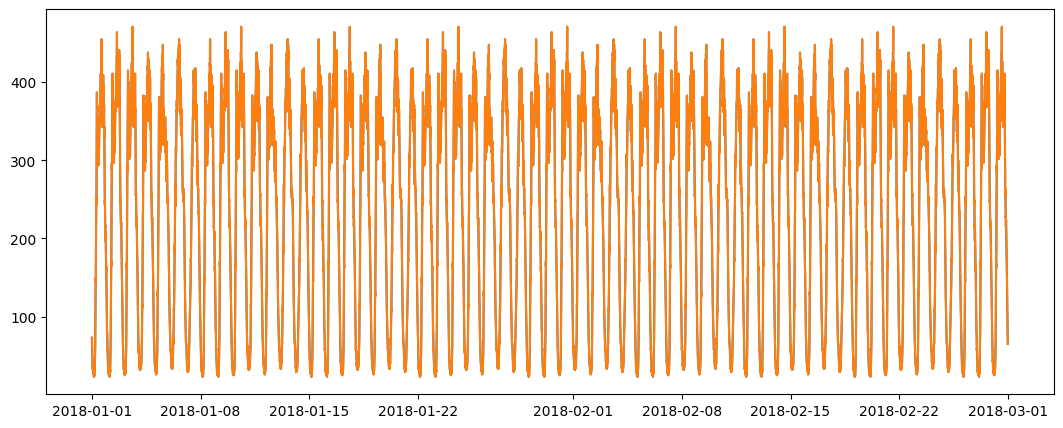

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(PeMS[261])
plt.plot(PeMS[169])

In [ ]:
node_colors ={node: 'red' if node in goodnodes else 'blue' for node in G.nodes}


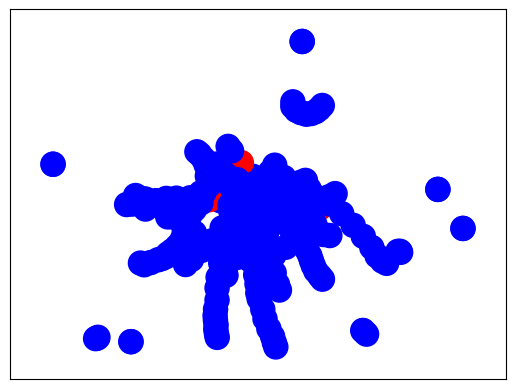

In [ ]:
nx.draw_networkx(G, with_labels=False, node_color=[node_colors[node] for node in G.nodes()])

In [ ]:
duplicate=PeMS.T.duplicated()

In [ ]:
print(PeMS.columns[duplicate])

Index([181, 179, 177, 170, 169], dtype='int64')


In [ ]:
print("Nodes which are better in multivariate" )
goodnodes = column_order[44:51]
print(goodnodes)

Nodes which are better in multivariate
[118, 261, 179, 177, 170, 169, 168]


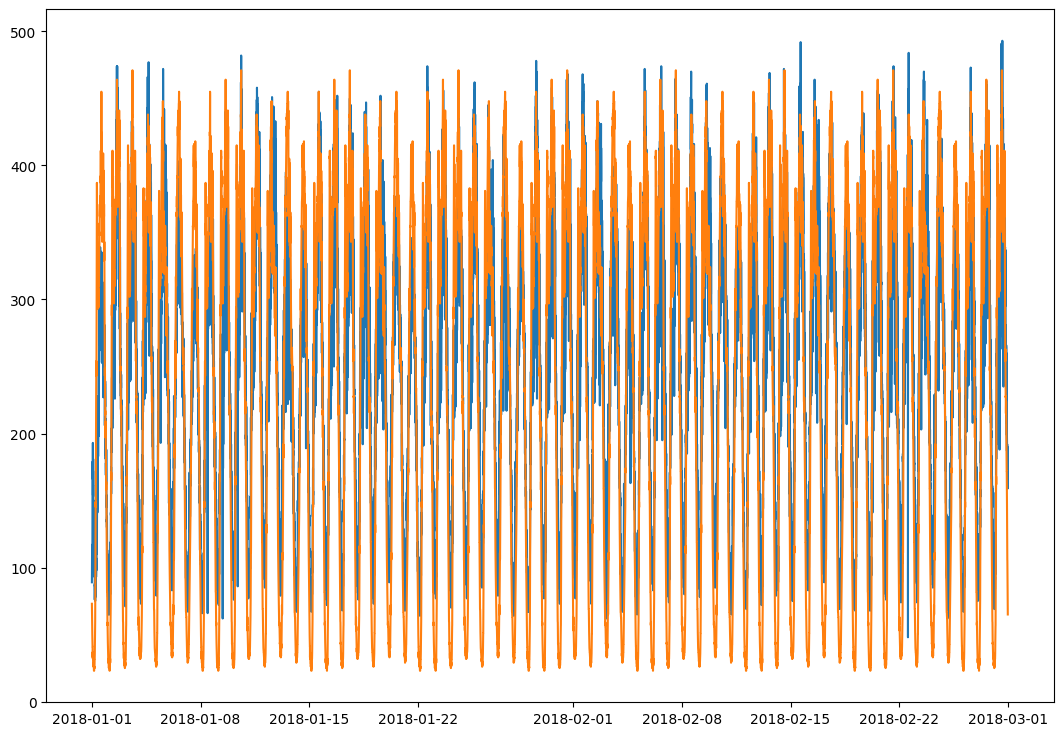

In [ ]:
plt.figure(figsize = (13,9))
plt.plot(PeMS[168])
plt.plot(PeMS[261])

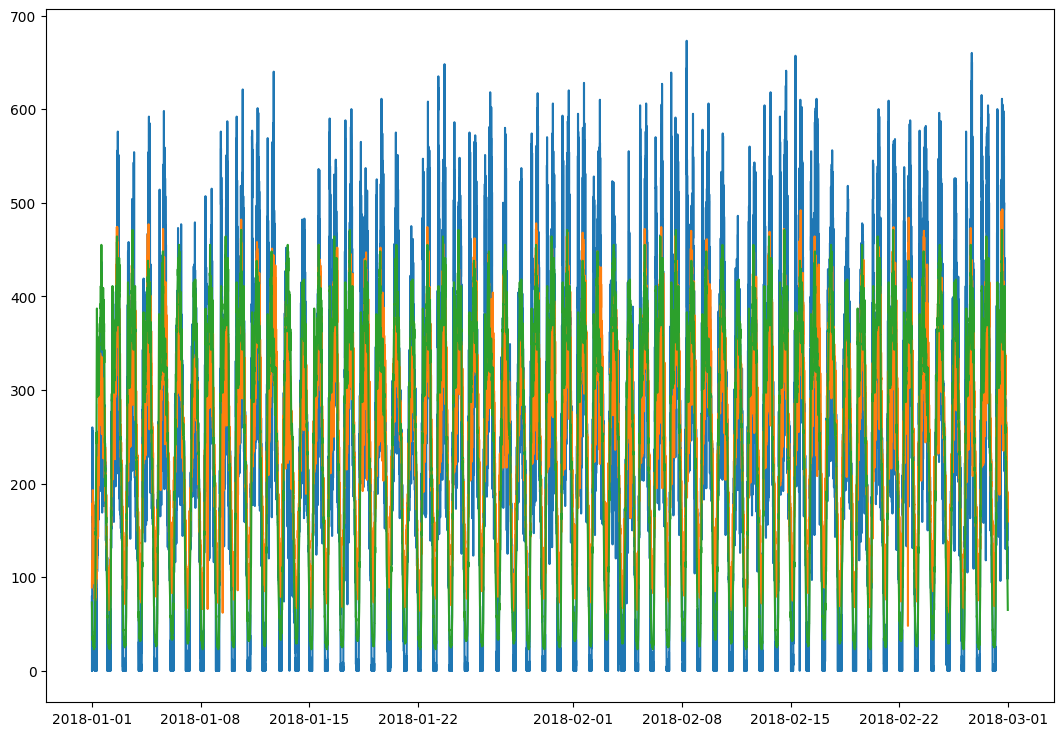

In [ ]:
plt.figure(figsize = (13,9))
plt.plot(PeMS[118])
plt.plot(PeMS[168])
plt.plot(PeMS[261])

In [ ]:
fedPeMS = PeMS[[118,168,261]]

In [ ]:
fedPeMS

,118,168,261
2018-01-01 00:00:00,79.0,89.0,73.0
2018-01-01 00:05:00,29.0,97.0,69.0
2018-01-01 00:10:00,0.0,96.0,66.0
2018-01-01 00:15:00,10.0,111.0,63.0
2018-01-01 00:20:00,0.0,117.0,60.0
...,...,...,...
2018-02-28 23:35:00,112.0,176.0,86.0
2018-02-28 23:40:00,132.0,181.0,86.0
2018-02-28 23:45:00,120.0,187.0,80.0
2018-02-28 23:50:00,99.0,159.0,73.0


In [ ]:
main_model = LSTMModel(input_size=1,output_size=1)

In [ ]:
fedPeMS

,118,168,261
2018-01-01 00:00:00,79.0,89.0,73.0
2018-01-01 00:05:00,29.0,97.0,69.0
2018-01-01 00:10:00,0.0,96.0,66.0
2018-01-01 00:15:00,10.0,111.0,63.0
2018-01-01 00:20:00,0.0,117.0,60.0
...,...,...,...
2018-02-28 23:35:00,112.0,176.0,86.0
2018-02-28 23:40:00,132.0,181.0,86.0
2018-02-28 23:45:00,120.0,187.0,80.0
2018-02-28 23:50:00,99.0,159.0,73.0


In [ ]:
datadict= local_dataset(fedPeMS,nodes=3)

ValueError: __len__() should return >= 0